# Load data 

#### First, we import some libraries

In [1]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error

# gradient boosting trees
from xgboost import XGBRegressor

# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")


from common import load_data, split_data

### Import data

In [2]:
data_dir = "../data/"
full_data = load_data(data_dir)

data = full_data["data"]
inputs_perf = full_data["performance_properties"]
inputs_feat = full_data["features"]
inputs_categ = full_data["features_categorical"]
inputs_num = full_data["features_numerical"]
inputs_feat_cols = full_data["feature_columns"]
inputs_prop = full_data["input_properties"]
inputs_name = full_data["input_names"]
inputs_count = full_data["input_counts"]

random_seed = 100
system = "gcc"
train_data, test_data, _ , _ = split_data(
    data, system, inputs_count, inputs_feat_cols, random_seed
)

np.random.seed(random_seed)

valid_training_percentages = [(k+1)/10 for k in range(9)] # 0.1 -> 0.9 included

train = dict()
val = dict()

for dkey in data.keys():
    soft, input_id = dkey
    for p in valid_training_percentages:
        X_train, X_test = train_test_split(data[soft, input_id], train_size=p)
        train[soft, input_id, p] = X_train
        val[soft, input_id, p] = X_test

### Compare supervised learning full online and the average baseline

In [3]:
name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite", "imagemagick"]

mape_rf = dict()
avgs = dict()

for ns in name_systems:
    for perf in inputs_perf[ns]:
        other_perf = [perf for perf in inputs_perf[ns]]
        other_perf.remove(perf)
        for pct in valid_training_percentages:
            for index_input in range(inputs_count[ns]):
                
                X_train = train[ns, index_input, pct].drop(other_perf, axis = 1).drop([perf], axis = 1)
                y_train = train[ns, index_input, pct][perf]

                clf = RandomForestRegressor()
                clf.fit(X_train, y_train)

                X_val = val[ns, index_input, pct].drop(other_perf, axis = 1).drop([perf], axis = 1)
                y_val = val[ns, index_input, pct][perf]
                y_rf = clf.predict(X_val)
                y_avg = np.mean(y_train)*np.ones(len(y_val))

                mape_rf[ns, perf, pct, index_input] = mean_absolute_percentage_error(y_rf, y_val)
                avgs[ns, perf, pct, index_input] = mean_absolute_percentage_error(y_avg, y_val)

In [4]:
mape_lr = dict()
mape_dt = dict()

for ns in name_systems:
    for perf in inputs_perf[ns]:
        other_perf = [perf for perf in inputs_perf[ns]]
        other_perf.remove(perf)
        for pct in valid_training_percentages:
            for index_input in range(inputs_count[ns]):
                
                X_train = train[ns, index_input, pct].drop(other_perf, axis = 1).drop([perf], axis = 1)
                y_train = train[ns, index_input, pct][perf]
                
                X_val = val[ns, index_input, pct].drop(other_perf, axis = 1).drop([perf], axis = 1)
                y_val = val[ns, index_input, pct][perf]
                
                lr = ElasticNet(l1_ratio = 0)
                lr.fit(X_train, y_train)
                y_lr = lr.predict(X_val)
                mape_lr[ns, perf, pct, index_input] = mean_absolute_percentage_error(y_lr, y_val)
                
                dt = DecisionTreeRegressor()
                dt.fit(X_train, y_train)
                y_dt = dt.predict(X_val)
                mape_dt[ns, perf, pct, index_input] = mean_absolute_percentage_error(y_dt, y_val)

In [5]:
mape_gb = dict()

for ns in name_systems:
    for perf in inputs_perf[ns]:
        other_perf = [perf for perf in inputs_perf[ns]]
        other_perf.remove(perf)
        for pct in valid_training_percentages:
            for index_input in range(inputs_count[ns]):
                
                X_train = train[ns, index_input, pct].drop(other_perf, axis = 1).drop([perf], axis = 1)
                y_train = train[ns, index_input, pct][perf]
                
                X_val = val[ns, index_input, pct].drop(other_perf, axis = 1).drop([perf], axis = 1)
                y_val = val[ns, index_input, pct][perf]
                
                gb = XGBRegressor()
                gb.fit(X_train, y_train)
                y_gb = gb.predict(X_val)
                mape_gb[ns, perf, pct, index_input] = mean_absolute_percentage_error(y_gb, y_val)

In [11]:
rq1_lines = []

for rl in mape_rf.keys():
    ns, perf, pct, index_input = rl
    rq1_lines.append((ns, perf, pct, index_input, "Average", 100*avgs[rl]))
    rq1_lines.append((ns, perf, pct, index_input, "OLS Regression", 100*mape_lr[rl]))
    rq1_lines.append((ns, perf, pct, index_input, "Decision Tree", 100*mape_dt[rl]))
    rq1_lines.append((ns, perf, pct, index_input, "Random Forest", 100*mape_rf[rl]))
    rq1_lines.append((ns, perf, pct, index_input, "Gradient Boosting", 100*mape_gb[rl]))

final_rq1 = pd.DataFrame(rq1_lines, columns = ["soft", "perf", "budget", "input", "Approach", "val"])

In [9]:
#final_rq1.to_csv('../results/RQ1_data.csv')

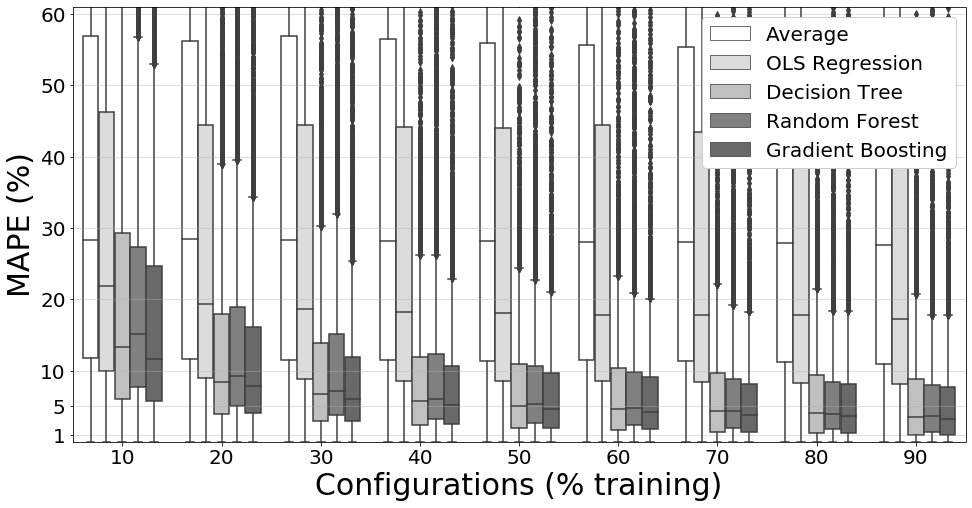

In [19]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

plt.grid(alpha=0.5)

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="budget", y="val",
            hue="Approach", 
            palette=["white", "gainsboro", "silver", "gray", "dimgray"],
            data=final_rq1, 
            showmeans=False, 
            meanprops={"marker":"x", "markeredgecolor":"black"},
           ax = ax)
plt.ylabel("MAPE (%)", size = 30)
plt.xlabel("Configurations (% training)", size = 30)
plt.ylim(0, 61)
plt.legend(fontsize=20, loc = 'upper right', framealpha=1)


# Arrow
# plt.arrow(x = 4.5, y = 2, dx= 0, dy = -0.3, head_width = 0.15, head_length = .1, color="orange")
# plt.text(s = "Better", x = 4, y = 1.95, size = 20, color = 'orange')
#ax.set_yscale('log')
#ax.tick_params(axis='both', which='major', labelsize=12)
#ax.get_yaxis().set_major_formatter(ScalarFormatter())
ax.set_yticks([1, 5, 10, 20, 30, 40, 50, 60], minor= False)
plt.yticks(size = 20)
ax.set_xticklabels([10*k for k in range(1, 10)])
plt.xticks(size = 20)
plt.savefig("../results/RQ1_eval.png", dpi = 300)
plt.show()

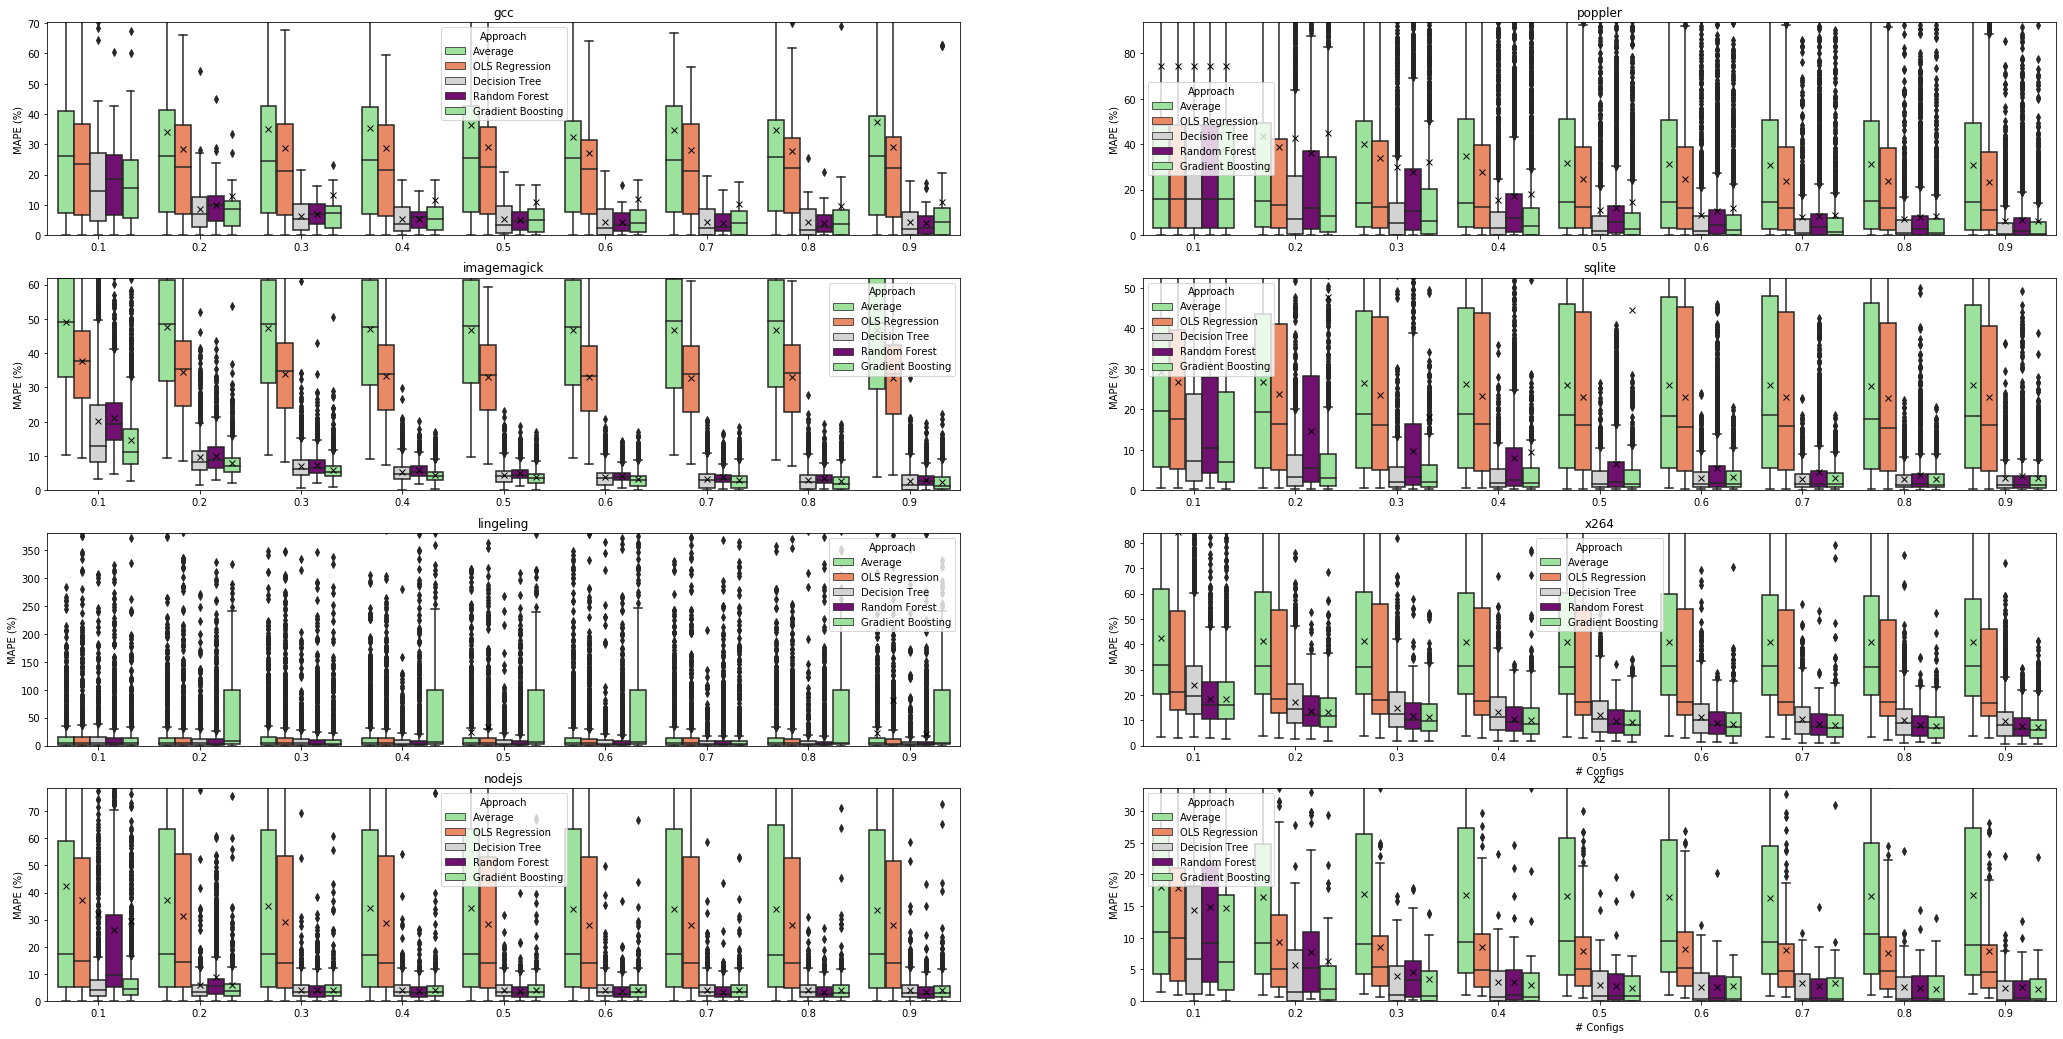

In [13]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(36, 18)

for i in range(len(name_systems)):
    soft = sorted(name_systems)[i]
    # Draw a nested boxplot to show bills by day and time
    sns.boxplot(x="budget", y="val",
                hue="Approach", 
                palette=["lightgreen", "coral", "lightgray", "purple"],
                data=final_rq1.query("soft=='"+soft+"'"), 
                showmeans=True, 
                meanprops={"marker":"x", "markeredgecolor":"black"},
                ax = axs[i%4, int(i/4)])
    axs[i%4, int(i/4)].set_ylabel("MAPE (%)", size = 10)
    if i >=6:
        axs[i%4, int(i/4)].set_xlabel("# Configs", size = 10)
    else:
        axs[i%4, int(i/4)].set_xlabel("")
    axs[i%4, int(i/4)].set_title(soft)
    axs[i%4, int(i/4)].set_ylim(0, np.percentile(final_rq1.query("soft=='"+soft+"'")["val"], 95))
    #plt.legend(fontsize=20, loc = 'upper right', framealpha=1)

# Arrow
# plt.arrow(x = 4.5, y = 2, dx= 0, dy = -0.3, head_width = 0.15, head_length = .1, color="orange")
# plt.text(s = "Better", x = 4, y = 1.95, size = 20, color = 'orange')

#plt.xticks(size = 20)
#plt.yticks(size = 20)
plt.savefig("../results/RQ1_eval_all.png")
plt.show()